<a href="https://colab.research.google.com/github/nealcaren/BIGSSS-LLM/blob/main/LLM_2_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Large Language Models as text classifiers with an sklearn interface

This notebook is lightly modified version of the [original](https://nbviewer.org/github/skorch-dev/skorch/blob/master/notebooks/LLM_Classifier.ipynb).

In this notebook, we will learn how to use [skorch](https://skorch.readthedocs.io/en/stable/)'s `ZeroShotClassifier` and `FewShotClassifier` to perform classification without any training thanks to the power of (Large) Language Models (LLMs). For this, we rely on the the [Hugging Face transformers](https://huggingface.co/docs/transformers/index) library, which allows us to use all the available text generation models provided by Hugging Face.

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch', 'transformers',])
except ImportError:
    pass

## Imports

In [2]:
import numpy as np
import pandas as pd
import transformers
import torch
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from google.colab import data_table
data_table.enable_dataframe_formatter()

# let's reduce some of the noise from transformers and datasets logs
transformers.logging.set_verbosity_warning()


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Load data

For this example, we make use of the IMDB dataset. It consists of movie reviews written by IMDB users and the target is the sentiment, i.e. "positive" or "negative".

In [4]:
imdb_df = pd.read_csv('https://www.dropbox.com/s/72n7a8u47mxntp9/IMDB%20Dataset.csv?raw=1')

We limit the number of samples to 100. Using zero/few-shot learning mostly makes sense when there are few labeled samples, otherwise, supervised machine learning methods will probably give better results.

In [5]:
imdb_dfs = imdb_df.groupby('sentiment').sample(50)
imdb_dfs = imdb_dfs.sample(frac=1.0)

X = imdb_dfs['review'].values
y = imdb_dfs['sentiment'].values

Let's take a quick look at the data. Our `X` contains the user reviews:

In [6]:
print(X[0])

To start out with, the script is immitative and inane. The characters are shallow and formulaic. The plot has arbitrary reversals and non sequitors. Baldwin's direction is terrible -- these actors could do better on their own. The jokes and wisecracks fall flat. The shoot out scenes are clumsy and incredible. Baldwin directs himself as the wise courageous hero but spends most of his time in power struggles with women, particularly with the caricatured repressedwoman in their tunnel team who is always asking for and denying reassurance. The conductor suffer from absurd incompetence, being unable to effectively employ a pistol he has come by.Anomalies: a hooded man bristleing with guns stalks through a railroad car, startling people. The next time we see them they are going about their business sitting in their seats, talking, eating, reading, knitting.In the New York subways folks sometimes come on the train to do some musical or dramatic number --- maybe that's what they thought the "h

Our `y` contains the label-encoded targets:

In [7]:
print(y[:5])

['negative' 'positive' 'negative' 'positive' 'positive']


For a standard machine learning solution, having label-encoded targets is desired. Here, we prefer to have the actual labels, however. It is much easier for the language model to predict the label "positive" for the text above than to predict "1". How would it know what "1" means? Sure, if we provide a few examples, it may work, but let's not make the language model's life harder than necessary and thus provide the actual labels.

## Zero-shot classification

Now let's see how we can use zero-shot classification with skorch. First, let's load the `ZeroShotClassifier` class:

In [8]:
from skorch.llm import ZeroShotClassifier

### "train" zero-shot classifier

For demonstration purposes, we use a small language model here, `flan-t5-small`, which is hosted on Hugging Face. It has the advantage that it's quite fast and, as we'll see, still performs quite well. For more details on this model, check out [its model card on Hugging Face](https://huggingface.co/google/flan-t5-small).

In [9]:
zs_clf = ZeroShotClassifier('google/flan-t5-small', device=device, use_caching=False)

Notes:

- `flan-t5` has an encoder-decoder architecture, for which caching is not available, which is why we turn it off. The loss of speed shouldn't matter much for this task.
- At the moment, we only support Hugging Face transformers models, or models that are compatible with it. We don't support APIs, so using OpenAI is not possible. For this, take a look at [scikit-llm](https://github.com/iryna-kondr/scikit-llm), which works with OpenAI. There are some restrictions associated with using an API, though, which means that not all features are available.

In [10]:
zs_clf.fit(X=None, y=['positive', 'negative'])

CPU times: user 4.08 s, sys: 1.79 s, total: 5.86 s
Wall time: 19.7 s


ZeroShotClassifier(device='cuda:0', model_name='google/flan-t5-small', use_caching=False)

In general, fitting is fast because, basically, nothing happens. If the transformers model and tokenizer are not cached locally, they will, however, be downloaded from Hugging Face, which may take some time.

### evaluation

Let's evaluate how well the model works. As with any sklearn-compatible model, we can just call `predict_proba` to get the probabilities that the model assigns to each sample:

In [11]:
y_proba = zs_clf.predict_proba(X)

Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 12 s, sys: 297 ms, total: 12.3 s
Wall time: 21 s


The prediction speed is a bit slow, as should be expected from a language model. If runtime is a big concern, this is probably not the right approach.

Now let's check how well the model does. First we check the log loss, then the accuracy:

In [12]:
log_loss(y, y_proba)

0.22249167700716818

In [13]:
y_pred = zs_clf.predict(X)

In [14]:
accuracy_score(y, y_pred)

0.95

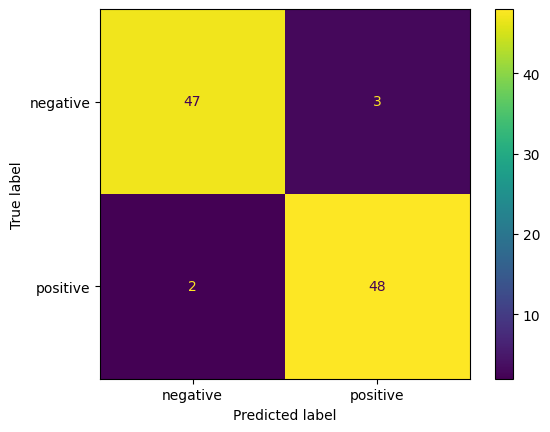

In [15]:
cm = confusion_matrix(y, y_pred, labels=zs_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=zs_clf.classes_)
disp.plot()


Given that this is zero-shot, those scores are actually not so bad!

Sure, on the [leaderboard](https://huggingface.co/spaces/autoevaluate/leaderboards?dataset=imdb&only_verified=0&task=-any-&config=-unspecified-&split=-unspecified-&metric=accuracy) we can find models with better accuracy, but those are fine-tuned on the dataset.

Notice that if we call `predict`, we get back the labels, i.e. "positive" or "negative".

In [16]:
zs_clf.predict(["A masterpiece, instant classic, 5 stars out of 5"])

array(['positive'], dtype='<U8')

What's the actual prompt?

In [17]:
print(zs_clf.get_prompt("A masterpiece, instant classic, 5 stars out of 5"))

You are a text classification assistant.

The text to classify:

```
A masterpiece, instant classic, 5 stars out of 5
```

Choose the label among the following possibilities with the highest probability.
Only return the label, nothing more:

['negative', 'positive']

Your response:



### Grid searching the prompt

Since `ZeroShotClassifier` is sckit-learn compatible, we can easily do a grid search for the best prompt. In this example, let's compare two different prompts that are worded slightly differently. Could one of them be the better choice?

In [18]:
prompt0 = """You are a text classification assistant.

The text to classify:

```
{text}
```

Choose the label among the following possibilities with the highest probability.
Only return the label, nothing more:

{labels}

Your response:
"""

In [19]:
prompt1 = """Your task is to classify text.

Choose the label among the following possibilities with the highest probability.
Only return the label, nothing more:

{labels}

The text to classify:

```
{text}
```

Your response:
"""

In [20]:
params = {'prompt': [prompt0, prompt1]}

In [21]:
search = GridSearchCV(zs_clf, param_grid=params, cv=2, scoring=['accuracy', 'neg_log_loss'], refit=False)

In [22]:
search.fit(X, y)

Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 44 s, sys: 1.1 s, total: 45.1 s
Wall time: 53 s


GridSearchCV(cv=2,
             estimator=ZeroShotClassifier(device='cuda:0', model_name='google/flan-t5-small', use_caching=False),
             param_grid={'prompt': ['You are a text classification assistant.\n'
                                    '\n'
                                    'The text to classify:\n'
                                    '\n'
                                    '```\n'
                                    '{text}\n'
                                    '```\n'
                                    '\n'
                                    'Choose the label among the following '
                                    'possibilities with the highest '
                                    'probability.\n'
                                    'Only return the label, nothing more:\n'
                                    '\n'
                                    '{labels}\n'
                                    '\n'
                                    'Your response:\n',
                                    'Your task is to classify text.\n'
                                    '\n'
                                    'Choose the label among the following '
                                    'possibilities with the highest '
                                    'probability.\n'
                                    'Only return the label, nothing more:\n'
                                    '\n'
                                    '{labels}\n'
                                    '\n'
                                    'The text to classify:\n'
                                    '\n'
                                    '```\n'
                                    '{text}\n'
                                    '```\n'
                                    '\n'
                                    'Your response:\n']},
             refit=False, scoring=['accuracy', 'neg_log_loss'])

grid search results:

In [23]:
pd.DataFrame(search.cv_results_)[['mean_test_accuracy', 'mean_test_neg_log_loss', 'param_prompt', 'mean_score_time']]

,mean_test_accuracy,mean_test_neg_log_loss,param_prompt,mean_score_time
0,0.95,-0.222492,You are a text classification assistant.\n\nTh...,10.537486
1,0.95,-0.233551,Your task is to classify text.\n\nChoose the l...,9.300972


**Conclusion**: `prompt1` is performing better than `prompt0`. The mean test accuracy of and log loss of are pretty good overall, given that we use zero-shot and don't perform any fine-tuning.

Going further, we could also grid search different language models, or combinations of LLMs and prompts, to find the best working zero-shot model.

## Few-shot classification

Sometimes, helping the language model out by providing a few examples will boost the performance. To test this, we skorch provides the `FewShotClassifier` class. Let's try it out.

In [24]:
from skorch.llm import FewShotClassifier
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

### train the few-shot classifier

Instead of passing the model name to initialize the classifier, as in `clf = FewShotClassifier('google/flan-t5-small')`, it is also possible to pass the model and tokenizer explicitly. This is a good option if you need more control over them. In our case, it amounts to the same result. It's useful to keep this option in mind, though, if the model requires any changes or if you want to provide a model that is not uploaded to Hugging Face.

In [25]:
model = AutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-small').to(device)
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-small')

To control the amount of samples used for few-shot learning, use `max_samples` parameter. In this case, let's use 5 examples:

In [26]:
fs_clf = FewShotClassifier(
    model=model, tokenizer=tokenizer, max_samples=5, use_caching=False
)

In [27]:
fs_clf.fit(X, y)

CPU times: user 1.27 ms, sys: 15 µs, total: 1.28 ms
Wall time: 1.48 ms


FewShotClassifier(model='T5ForConditionalGeneration', tokenizer='T5TokenizerFast', use_caching=False)

Let's make sure that everything works as expected by inspecting the prompt. This is possible using the `get_prompt` method:

In [28]:
print(fs_clf.get_prompt("A masterpiece, instant classic, 5 stars out of 5"))

You are a text classification assistant.

Choose the label among the following possibilities with the highest probability.
Only return the label, nothing more:

['negative', 'positive']

Here are a few examples:

```
This is a great flick! It is funny for everyone, even adults. We got Jason Voorhees/Leatherface like killer in this, along with other wacky characters. Very funny flick, for children of all ages. Must of rented this every time we went to the video store! Buster and Babs make a good pair, and gotta love the duck. He is probably my favorite character! I was never big on the TV show but this movie just brings back so many great memories. Must see for families, fans of the show, or anyone! Enjoyable no matter how small or old you are! RENT IT NOW AT YOUR LOCAL VIDEO STORE!<br /><br />P.S. NEEDS A DVD RELEASE!
```

Your response:
positive

```
IQ is a wonderfully original romantic comedy that pits the greatest and deepest-thinking scientific minds of the 20th century as Cupid's

If we're unhappy with the prompt, we can also provide our own prompt using the `prompt` argument, as we saw earlier in this notebook.

### evaluation

In [29]:
y_proba = fs_clf.predict_proba(X)

Token indices sequence length is longer than the specified maximum sequence length for this model (1634 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 19.5 s, sys: 63.4 ms, total: 19.6 s
Wall time: 19.8 s


In [30]:
log_loss(y, y_proba)

0.17549397040642958

In [31]:
y_pred = fs_clf.predict(X)

In [32]:
accuracy_score(y, y_pred)

0.95

In [33]:
fs_clf.predict(["Even if paid $1000, I would not watch this movie again"])

array(['negative'], dtype=object)

This looks like a small improvement over what we got with zero-shot learning. Let's see if we can get even better.

### grid search best number of few-shot samples

Maybe we can do even better if we pick a better number of samples for few-shot learning? Let's try this out with grid search.

Note that grid search will split `X` and `y` for each run. Since the few-shot samples are taken from `X` and `y`, those will thus be different for each split, which could have a big influence on the performance of the model. If you always want to have the same few-shot samples in each split, you should craft your own prompt with those examples and then use it with `ZeroShotClassifier`. Just ensure that those prompts are not part of the validation/test data!

Now let's test 1, 3, and 5 samples and see what works best.

In [34]:
params = {'max_samples': [1, 3, 5]}

In [35]:
search = GridSearchCV(fs_clf,
                      param_grid=params,
                      cv=3,
                      scoring=['accuracy', 'neg_log_loss'],
                      refit=False)

In [36]:
search.fit(X, y)

CPU times: user 1min 58s, sys: 319 ms, total: 1min 58s
Wall time: 2min 7s


GridSearchCV(cv=3,
             estimator=FewShotClassifier(model=T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_...
), tokenizer=T5TokenizerFast(name_or_path='google/flan-t5-small', vocab_size=32100, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>', '<extra_id_46>', '<extra_id_47>', '<extra_id_48>', '<extra_id_49>', '<extra_id_50>', '<extra_id_51>', '<extra_id_52>', '<extra_id_53>', '<extra_id_54>', '<extra_id_55>', '<extra_id_56>', '<extra_id_57>', '<extra_id_58>', '<extra_id_59>', '<extra_id_60>', '<extra_id_61>', '<extra_id_62>', '<extra_id_63>', '<extra_id_64>', '<extra_id_65>', '<extra_id_66>', '<extra_id_67>', '<extra_id_68>', '<extra_id_69>', '<extra_id_70>', '<extra_id_71>', '<extra_id_72>', '<extra_id_73>', '<extra_id_74>', '<extra_id_75>', '<extra_id_76>', '<extra_id_77>', '<extra_id_78>', '<extra_id_79>', '<extra_id_80>', '<extra_id_81>', '<extra_id_82>', '<extra_id_83>', '<extra_id_84>', '<extra_id_85>', '<extra_id_86>', '<extra_id_87>', '<extra_id_88>', '<extra_id_89>', '<extra_id_90>', '<extra_id_91>', '<extra_id_92>', '<extra_id_93>', '<extra_id_94>', '<extra_id_95>', '<extra_id_96>', '<extra_id_97>', '<extra_id_98>', '<extra_id_99>']}, clean_up_tokenization_spaces=True), use_caching=False),
             param_grid={'max_samples': [1, 3, 5]}, refit=False,
             scoring=['accuracy', 'neg_log_loss'])

In [37]:
pd.DataFrame(search.cv_results_)[['mean_test_accuracy', 'mean_test_neg_log_loss', 'param_max_samples', 'mean_score_time']]

,mean_test_accuracy,mean_test_neg_log_loss,param_max_samples,mean_score_time
0,0.950683,-0.193950,1,6.435525
1,0.960487,-0.180730,3,10.487410
2,0.950683,-0.181068,5,24.928518


**Conclusion**: There is no significant change in accuracy compared to zero-shot but a small improvement in log loss. Having more samples doesn't help but slows down the inference time, as we can see when looking at `mean_score_time`. Overall, few-shot learning helps a bit but makes inference slower. It's up to you to decide if the trade-off is worth it in this specific case.

**Your turn:** Back to the emotions dataset!

In [38]:
emotions_df_full = pd.read_csv('https://www.dropbox.com/scl/fi/5811cfclfulyz31ardgzu/emotions_16K.csv?dl=1&rlkey=jztgt5fpbcqa82mbq554gpbsg')

In [39]:
emotions_df = emotions_df_full.groupby("emotion").sample(n=20)

print(len(emotions_df))
emotions_df.sample(3)

120


,text,emotion
1534,i feel some control over caring for the little...,love
13959,i never feel accepted but you have to go throu...,love
15762,i feel like i am supposed to be faithful to her,love


In [40]:
elabels = sorted(list(emotions_df['emotion'].value_counts().index))
elabels

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [41]:
ez_clf = ZeroShotClassifier('google/flan-t5-base', device=device, use_caching=False)

In [42]:
ez_clf.fit(X=None, y=elabels)

ZeroShotClassifier(device='cuda:0', model_name='google/flan-t5-base', use_caching=False)

In [43]:
tweet = 'i left feeling thoroughly invigorated and ready to face a new year of craft challenges so big kudos to the wonderful organizers at hello craft for a truly awesome summit'

ez_clf.predict([tweet])

array(['joy'], dtype='<U8')

**Your turn:** Can you improve on this model?

In [44]:
y_pred = ez_clf.predict(emotions_df['text'])

Accuracy:  0.575


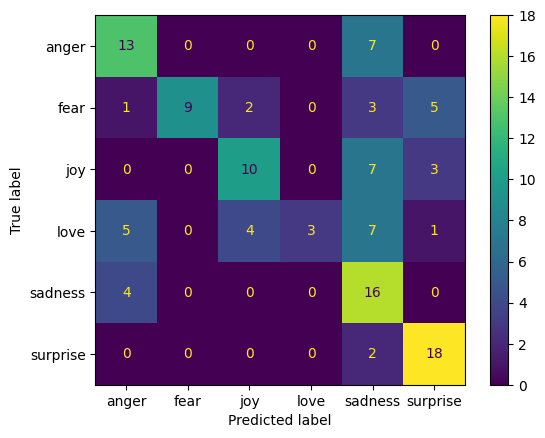

In [45]:
cm = confusion_matrix(emotions_df['emotion'], y_pred, labels=ez_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=ez_clf.classes_)
disp.plot()
print('Accuracy: ',accuracy_score(emotions_df['emotion'], y_pred))